### Downloading necessary dependencies

In [ ]:
!pip install wget tensorflow pandas numpy keras

### Downloading CLINC150 Dataset and Glove word vector

In [3]:
import wget
url = 'https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_full.json'
wget.download(url)

url = 'https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
wget.download(url)

'glove.6B.100d.txt'

### Dataset preparing

In [4]:
import numpy as np
import json

In [5]:
# Loading json data
with open('data_full.json') as file:
  data = json.loads(file.read())

# Loading out-of-scope intent data
val_oos = np.array(data['oos_val'])
train_oos = np.array(data['oos_train'])
test_oos = np.array(data['oos_test'])

# Loading other intents data
val_others = np.array(data['val'])
train_others = np.array(data['train'])
test_others = np.array(data['test'])

# Merging out-of-scope and other intent data
val = np.concatenate([val_oos,val_others])
train = np.concatenate([train_oos,train_others])
test = np.concatenate([test_oos,test_others])

In [ ]:
data

In [11]:
data['train'][0]

['what expression would i use to say i love you if i were an italian',
 'translate']

In [15]:
data = np.concatenate([train,test,val])
data = data.T

text = data[0]
labels = data[1]

In [28]:
text[1000], labels[1000]

('what steps should i take to improve my credit score', 'improve_credit_score')

###Splitting the dataset

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
train_txt,test_txt,train_label,test_labels = train_test_split(text,labels,test_size = 0.3)

### Preprocessing split dataset

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [34]:
ls=[]
for c in train_txt:
    ls.append(len(c.split()))
maxLen=int(np.percentile(ls, 98))

In [50]:
embeddings_index={}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [51]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(0.004451992, 0.4081574)

In [54]:
max_num_words = 40000
embedding_dim=len(embeddings_index['the'])
classes = np.unique(labels)

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_txt)

train_sequences = tokenizer.texts_to_sequences(train_txt)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen, padding='post')
test_sequences = tokenizer.texts_to_sequences(test_txt)
test_sequences = pad_sequences(test_sequences, maxlen=maxLen, padding='post')
word_index = tokenizer.word_index

In [ ]:
word_index

In [58]:
train_txt[0]

'how old will you be this year'

In [59]:
train_sequences[0]

array([ 11, 367,  34,   5,  35,  40, 204,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [66]:
num_words = min(max_num_words, len(word_index) )+1
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [82]:
num_words

6307

In [73]:
embedding_matrix.shape

(6307, 100)

In [74]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [75]:
train_label_encoded = label_encoder.transform(train_label)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded), 1)
train_label = onehot_encoder.transform(train_label_encoded)

In [76]:
test_labels_encoded = label_encoder.transform(test_labels)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels = onehot_encoder.transform(test_labels_encoded)

### Model preparation

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional,Embedding

In [79]:
model = Sequential()

model.add(Embedding(num_words, 100, trainable=False,input_length=train_sequences.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(classes.shape[0], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           630700    
                                                                 
 bidirectional (Bidirectiona  (None, 16, 512)          731136    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 50)                12850     
                                                        

In [80]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [81]:
history = model.fit(train_sequences, train_label, epochs = 20,
          batch_size = 64, shuffle=True,
          validation_data=[test_sequences, test_labels])

Epoch 1/20
260/260 [==============================] - 73s 224ms/step - loss: 4.5924 - acc: 0.0612 - val_loss: 3.5820 - val_acc: 0.1269
Epoch 2/20
260/260 [==============================] - 59s 225ms/step - loss: 3.0697 - acc: 0.2120 - val_loss: 2.0566 - val_acc: 0.4515
Epoch 3/20
260/260 [==============================] - 56s 217ms/step - loss: 2.0838 - acc: 0.4156 - val_loss: 1.3940 - val_acc: 0.6023
Epoch 4/20
260/260 [==============================] - 58s 223ms/step - loss: 1.5340 - acc: 0.5640 - val_loss: 1.0284 - val_acc: 0.7058
Epoch 5/20
260/260 [==============================] - 56s 217ms/step - loss: 1.2053 - acc: 0.6508 - val_loss: 0.8636 - val_acc: 0.7534
Epoch 6/20
260/260 [==============================] - 58s 224ms/step - loss: 0.9825 - acc: 0.7216 - val_loss: 0.7828 - val_acc: 0.7774
Epoch 7/20
260/260 [==============================] - 58s 222ms/step - loss: 0.8181 - acc: 0.7664 - val_loss: 0.6955 - val_acc: 0.8023
Epoch 8/20
260/260 [==============================] - 5

### Metrics visualization

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

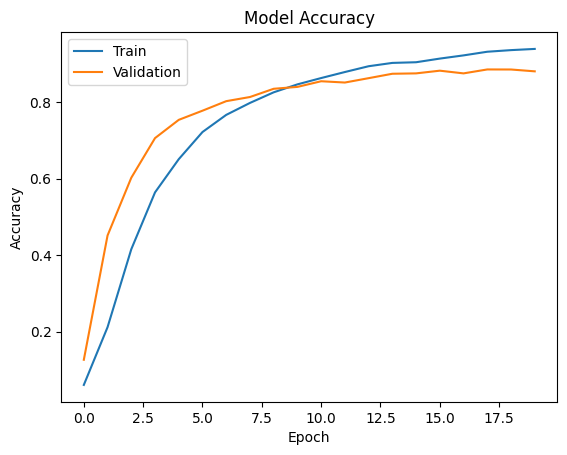

In [84]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

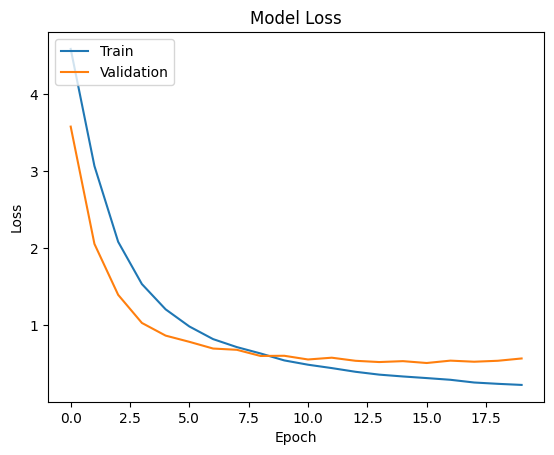

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Saving Model, Tokenizer, Label Encoder and Labels

In [86]:
import pickle
import json

In [88]:
model.save('models/intents.h5')

with open('utils/classes.pkl','wb') as file:
   pickle.dump(classes,file)

with open('utils/tokenizer.pkl','wb') as file:
   pickle.dump(tokenizer,file)

with open('utils/label_encoder.pkl','wb') as file:
   pickle.dump(label_encoder,file)

### Predicting on real-time examples

In [89]:
class IntentClassifier:
    def __init__(self,classes,model,tokenizer,label_encoder):
        self.classes = classes
        self.classifier = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder

    def get_intent(self,text):
        self.text = [text]
        self.test_keras = self.tokenizer.texts_to_sequences(self.text)
        self.test_keras_sequence = pad_sequences(self.test_keras, maxlen=16, padding='post')
        self.pred = self.classifier.predict(self.test_keras_sequence)
        return label_encoder.inverse_transform(np.argmax(self.pred,1))[0]

In [91]:
import pickle

from tensorflow.keras.models import load_model

model = load_model('models/intents.h5')

with open('utils/classes.pkl','rb') as file:
  classes = pickle.load(file)

with open('utils/tokenizer.pkl','rb') as file:
  tokenizer = pickle.load(file)

with open('utils/label_encoder.pkl','rb') as file:
  label_encoder = pickle.load(file)

In [92]:
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)

In [93]:
nlu.get_intent("is it cold in India right now")

1/1 [==============================] - 1s 691ms/step


'weather'

In [102]:
nlu.get_intent("Hey guy")

1/1 [==============================] - 0s 71ms/step


'greeting'

In [99]:
classes

array(['accept_reservations', 'account_blocked', 'alarm',
       'application_status', 'apr', 'are_you_a_bot', 'balance',
       'bill_balance', 'bill_due', 'book_flight', 'book_hotel',
       'calculator', 'calendar', 'calendar_update', 'calories', 'cancel',
       'cancel_reservation', 'car_rental', 'card_declined', 'carry_on',
       'change_accent', 'change_ai_name', 'change_language',
       'change_speed', 'change_user_name', 'change_volume',
       'confirm_reservation', 'cook_time', 'credit_limit',
       'credit_limit_change', 'credit_score', 'current_location',
       'damaged_card', 'date', 'definition', 'direct_deposit',
       'directions', 'distance', 'do_you_have_pets', 'exchange_rate',
       'expiration_date', 'find_phone', 'flight_status', 'flip_coin',
       'food_last', 'freeze_account', 'fun_fact', 'gas', 'gas_type',
       'goodbye', 'greeting', 'how_busy', 'how_old_are_you',
       'improve_credit_score', 'income', 'ingredient_substitution',
       'ingredients_l

In [103]:
!tar -czvf model_nlu.tar.gz /content/models

tar: Removing leading `/' from member names
/content/models/
/content/models/intents.h5


In [104]:
!tar -czvf utils_nlu.tar.gz /content/utils

tar: Removing leading `/' from member names
/content/utils/
/content/utils/label_encoder.pkl
/content/utils/classes.pkl
/content/utils/tokenizer.pkl
